In [18]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import math
from torch import nn, optim
import torch
import torch.nn.functional as F
from torch.autograd import Variable

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [104]:
data_path = "./kmrd/kmr_dataset/datafile/kmrd-small"

In [33]:
def read_data(data_path):
    data = pd.read_csv(os.path.join(data_path,"rates.csv"))
    train_df, test_df = train_test_split(data, test_size= 0.2, random_state= 1234, shuffle= True)
    return train_df, test_df

In [34]:
# 학습할 영화 데이터 분석
train_df, val_df = read_data(data_path)

In [38]:
print(train_df.shape)
train_df.head()

(112568, 4)


,user,movie,rate,time
137023,48423,10764,10,1212241560
92868,17307,10170,10,1122185220
94390,18180,10048,10,1573403460
22289,1498,10001,9,1432684500
80155,12541,10022,10,1370458140


In [39]:
print(test_df.shape)
test_df.head()

(28142, 4)


,user,movie,rate,time
76196,11242,10253,10,1437788760
109800,26903,10102,10,1322643900
60479,7101,10007,1,1314804000
71460,9705,10016,10,1228825200
73864,10616,10106,8,1425046200


<AxesSubplot:>

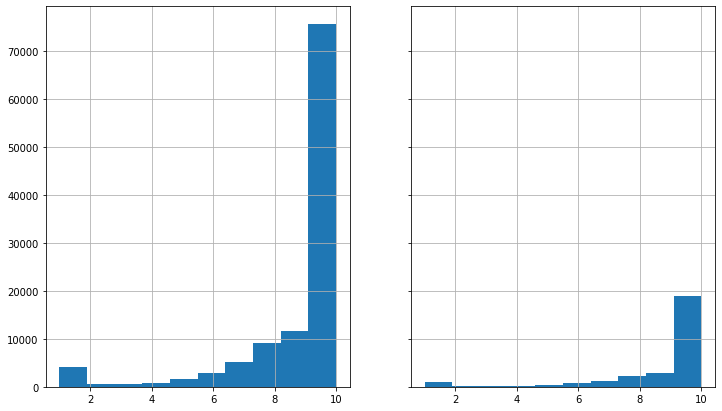

In [45]:
fig, ax = plt.subplots(1,2, sharex = 'col', sharey = "row", figsize = (12,7))
ax = ax.ravel()

train_df["rate"].hist(ax = ax[0])
test_df["rate"].hist(ax = ax[1])


In [46]:
# Load all related dataframe
movies_df = pd.read_csv(os.path.join(data_path, 'movies.txt'), sep='\t', encoding='utf-8')
movies_df = movies_df.set_index('movie')

castings_df = pd.read_csv(os.path.join(data_path, 'castings.csv'), encoding='utf-8')
countries_df = pd.read_csv(os.path.join(data_path, 'countries.csv'), encoding='utf-8')
genres_df = pd.read_csv(os.path.join(data_path, 'genres.csv'), encoding='utf-8')

# Get genre information
genres = [(list(set(x['movie'].values))[0], '/'.join(x['genre'].values)) for index, x in genres_df.groupby('movie')]
combined_genres_df = pd.DataFrame(data=genres, columns=['movie', 'genres'])
combined_genres_df = combined_genres_df.set_index('movie')

# Get castings information
castings = [(list(set(x['movie'].values))[0], x['people'].values) for index, x in castings_df.groupby('movie')]
combined_castings_df = pd.DataFrame(data=castings, columns=['movie','people'])
combined_castings_df = combined_castings_df.set_index('movie')

# Get countries for movie information
countries = [(list(set(x['movie'].values))[0], ','.join(x['country'].values)) for index, x in countries_df.groupby('movie')]
combined_countries_df = pd.DataFrame(data=countries, columns=['movie', 'country'])
combined_countries_df = combined_countries_df.set_index('movie')

movies_df = pd.concat([movies_df, combined_genres_df, combined_castings_df, combined_countries_df], axis=1)


In [47]:
movies_df

,title,title_eng,year,grade,genres,people,country
movie,,,,,,,
10001,시네마 천국,"Cinema Paradiso , 1988",2013.0,전체 관람가,드라마/멜로/로맨스,"[4374, 178, 3241, 47952, 47953, 19538, 18991, ...","이탈리아,프랑스"
10002,빽 투 더 퓨쳐,"Back To The Future , 1985",2015.0,12세 관람가,SF/코미디,"[1076, 4603, 917, 8637, 5104, 9986, 7470, 9987]",미국
10003,빽 투 더 퓨쳐 2,"Back To The Future Part 2 , 1989",2015.0,12세 관람가,SF/코미디,"[1076, 4603, 917, 5104, 391, 5106, 5105, 5107,...",미국
10004,빽 투 더 퓨쳐 3,"Back To The Future Part III , 1990",1990.0,전체 관람가,서부/SF/판타지/코미디,"[1076, 4603, 1031, 5104, 10001, 5984, 10002, 1...",미국
10005,스타워즈 에피소드 4 - 새로운 희망,"Star Wars , 1977",1997.0,PG,판타지/모험/SF/액션,"[1007, 535, 215, 1236, 35]",미국
...,...,...,...,...,...,...,...
10995,공포의 여정,"Journey Into Fear , 1975",NaN,PG,스릴러,"[2464, 16573, 2101, 10619, 17815, 17814, 16848...",미국
10996,버스틴 루즈,"Bustin' Loose , 1981",NaN,R,코미디,"[9598, 6520, 506, 11123]",미국
10997,블랙 엔젤,"Mausoleum , 1983",NaN,청소년 관람불가,공포,"[198255, 17831, 10233, 140473, 31534, 200668, ...",미국


In [129]:
class DataLoader:
    def __init__(self, data_path):
        self.train_df, val_df = self.read_data(data_path)
        self.min_rating = self.train_df.rate.min()
        self.max_rating = self.train_df.rate.max()
        
        # user2index
        self.unique_users = self.train_df.user.unique()
        self.user_to_index = {user:idx for idx, user in enumerate(self.unique_users)}
        self.num_users = len(self.unique_users)
        
        # movie2index
        self.unique_movies = self.train_df.movie.unique()
        self.movie_to_index = {movie:idx for idx, movie in enumerate(self.unique_movies)}
        self.num_movies = len(self.unique_movies)
        
        # val다시 선언 -> 학습된 데이터 내에 있는 것으로만 구성해야 하기 때문임.
        self.val_df = val_df[val_df.user.isin(self.unique_users) & val_df.movie.isin(self.unique_movies)]
        
    def generate_trainset(self):
        X_train = pd.DataFrame({'user': self.train_df.user.map(self.user_to_index),
                                'movie': self.train_df.movie.map(self.movie_to_index)})
        y_train = self.train_df.rate.astype(np.float32)
        return X_train, y_train
    
    def generate_valset(self):
        X_val = pd.DataFrame({'user': self.val_df.user.map(self.user_to_index),
                              'movie': self.val_df.movie.map(self.movie_to_index)})
        y_val = self.val_df.rate.astype(np.float32)
        return X_val, y_val
        
    def read_data(self, data_path):
        data = pd.read_csv(os.path.join(data_path,"rates.csv"))
        train_df, test_df = train_test_split(data, test_size= 0.2, random_state= 1234, shuffle= True)
        return train_df, test_df

In [130]:
ds = DataLoader(data_path)

In [183]:
# model structure

class FeedForwardEmbedNN(nn.Module):
    def __init__(self, n_users, n_movies, hidden, dropouts, n_factors, embedding_dropout):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, n_factors)
        self.movie_emb = nn.Embedding(n_movies, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden_layers = nn.Sequential(*list(self.generate_layers(n_factors*2, hidden, dropouts)))
        self.fc = nn.Linear(hidden[-1], 1)
        
    def generate_layers(self, n_factors, hidden, dropouts):
        assert len(dropouts) == len(hidden)
        # yield를 이용해서 generator를 만들 수 있음 -> lazy manner로 코드가 구현되어서 훨씬 효과적임
        idx = 0
        while idx < len(hidden):
            if idx == 0:
                yield nn.Linear(n_factors, hidden[idx])
            else:
                yield nn.Linear(hidden[idx-1], hidden[idx])
            yield nn.ReLU()
            yield nn.Dropout(dropouts[idx])
            
            idx += 1
    
    def forward(self,users, movies, min_rating = 0.5, max_rating = 10):
        concat_features = torch.cat([self.user_emb(users), self.movie_emb(movies)], dim = 1)
        x = F.relu(self.hidden_layers(concat_features))
        
        out = torch.sigmoid(self.fc(x))
        # rating으로 변환 (이따가 min-max로 변환해주나?)
        out = out * (max_rating - min_rating) + min_rating
        return out
        
    def predict(self, users, movies):
        return self.forward(users, movies)

In [184]:
class BatchIterator:
    def __init__(self, X,y, batch_size = 32, shuffle = True):
        X,y = np.array(X), np.array(y)
        if shuffle:
            index = np.random.permutation(X.shape[0])
            X,y = X[index], y[index]
        
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0
    
    def __iter__(self):
        return self
    
    
    def __next__(self):
        return self.next()
    
        
    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k*bs: (k+1)*bs], self.y[k*bs : (k+1)*bs]
        

In [185]:
def batches(X,y, bs = 32, shuffle = True):
    for x_batch, y_batch in BatchIterator(X,y,bs,shuffle):
        x_batch = torch.LongTensor(x_batch)
        y_batch = torch.FloatTensor(y_batch)
        yield x_batch, y_batch.view(-1,1)

In [186]:
def model_train(ds, config):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    X_train, y_train = ds.generate_trainset()
    X_valid, y_valid = ds.generate_valset()

    model = FeedForwardEmbedNN(
        n_users= ds.num_users, n_movies= ds.num_movies,
        n_factors= config["num_factors"], hidden = config["hidden_layers"],
        embedding_dropout = config["embedding_dropout"], dropouts = config["dropouts"])
    model.to(device)

    batch_size = config["batch_size"]
    num_epochs = config["num_epochs"]
    max_patience = config["total_patience"]
    num_patience = 0
    best_loss = np.inf

    criterion = nn.MSELoss(reduction = "sum")
    criterion.to(device)
    optimizer = optim.Adam(model.parameters(),
                           lr = config["learning_rate"],
                           weight_decay=config['weight_decay'])
    result = dict()
    for epoch in tqdm(range(num_epochs)):
        training_loss = 0.0
        for batch in batches(X_train, y_train, shuffle = True, bs = batch_size):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(x_batch[:,0], x_batch[:,1], ds.min_rating, ds.max_rating)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
            training_loss += loss.item()
        result["train"] = training_loss / len(X_train) #?


        with torch.no_grad():
            # apply early stopping
            val_outputs = model(torch.LongTensor(X_valid.user.values).to(device),
                                torch.LongTensor(X_valid.movie.values).to(device),
                                ds.min_rating, ds.max_rating)
            val_loss = criterion(val_outputs.to(device),
                                 torch.FloatTensor(y_valid.values).view(-1,1).to(device))
            result["val"] = float( (val_loss/len(X_valid)).data )

        if val_loss < best_loss:
            print("Save new model on epoch %d" % (epoch + 1))
            best_loss = val_loss
            result["best_loss"] = val_loss
            torch.save(model.state_dict(), config["save_path"])
            num_patience = 0
        else:
            num_patience += 1

        print(f'[epoch: {epoch+1}] train: {result["train"]} - val: {result["val"]}')

        if num_patience >= max_patience:
            print(f"Early Stopped afeter epoch{epoch+1}")
            break

    return result


In [187]:
dataset = DataLoader(data_path)
dataset.num_movies

597

In [188]:
config = {
  "num_factors": 16,
  "hidden_layers": [64, 32, 16],
  "embedding_dropout": 0.05,
  "dropouts": [0.3, 0.3, 0.3],
  "learning_rate": 1e-3,
  "weight_decay": 1e-5,
  "batch_size": 8,
  "num_epochs": 3,
  "total_patience": 30,
  "save_path": "params.data"
}

In [189]:
model_train(dataset, config)

 33%|██████████████▎                            | 1/3 [01:07<02:15, 67.62s/it]

Save new model on epoch 1
[epoch: 1] train: 4.334581077140148 - val: 3.8364861011505127


 67%|████████████████████████████▋              | 2/3 [02:15<01:07, 67.78s/it]

Save new model on epoch 2
[epoch: 2] train: 3.69968118569264 - val: 3.560492992401123


100%|███████████████████████████████████████████| 3/3 [03:24<00:00, 68.02s/it]

Save new model on epoch 3
[epoch: 3] train: 3.2781147468511724 - val: 3.5242252349853516


{'train': 3.2781147468511724,
 'val': 3.5242252349853516,
 'best_loss': tensor(71386.7031, device='cuda:0')}

In [190]:

val_df.head()

,user,movie,rate,time
76196,11242,10253,10,1437788760
109800,26903,10102,10,1322643900
60479,7101,10007,1,1314804000
71460,9705,10016,10,1228825200
73864,10616,10106,8,1425046200


In [191]:
def model_valid(user_id_list, movie_id_list, data_path):
    dataset = DataLoader(data_path)
    processed_test_input_df = pd.DataFrame({
        'user_id': [dataset.user_to_index[x] for x in user_id_list],
        'movie_id': [dataset.movie_to_index[x] for x in movie_id_list]
    })

    # 학습한 모델 load하기 
    my_model = FeedForwardEmbedNN(dataset.num_users, dataset.num_movies,
                       config['hidden_layers'], config['dropouts'], config['num_factors'], config['embedding_dropout'])
    my_model.load_state_dict(torch.load('params.data'))
    prediction_outputs = my_model.predict(users=torch.LongTensor(processed_test_input_df.user_id.values),
                     movies=torch.LongTensor(processed_test_input_df.movie_id.values))

    return prediction_outputs

In [193]:
movie_id_list = [10253, 10102, 10007]
user_id = 11242
user_id_list = [user_id] * len(movie_id_list)
pred_results = [float(x) for x in model_valid(user_id_list, movie_id_list, data_path)]

result_df = pd.DataFrame({
    "userId": user_id_list,
    "movieId": movie_id_list,
    "pred_ratings": pred_results
})

In [194]:
result_df.sort_values(by = "pred_ratings", ascending=False)

,userId,movieId,pred_ratings
1,11242,10102,9.805676
2,11242,10007,9.740163
0,11242,10253,9.479564


In [195]:
val_df[val_df.user == 11242]

,user,movie,rate,time
76196,11242,10253,10,1437788760
76191,11242,10020,10,1435493160
76197,11242,10479,10,1437611280
